In [43]:
import pandas as pd
from modules import constants
from modules.functions import convert_box_score_dataframe_to_regression_format,add_calculated_metrics_to_preprocessed_dataframe
from sklearn.linear_model import Ridge
from modules.objects import RegressionHub
team_id_name_dict = {v:k for k,v in constants.TEAM_NAME_ID_DICT.items()}
from datetime import datetime
today = str(datetime.today()).split(" ")[0]

Read in full data filter on D1 games only

In [44]:
full_box_df = pd.read_parquet('parquet_files/box_scores_sports_reference_2024.gzip')
metrics_df = add_calculated_metrics_to_preprocessed_dataframe(full_box_df)
reg_df = convert_box_score_dataframe_to_regression_format(metrics_df)
print(reg_df.shape)
games_df = reg_df.drop(['ortg','drtg','pace','to_pct','opp_to_pct','game_date','ui'],axis = 1).copy()
y_df = reg_df[['ortg','drtg','pace']].copy()

parameter_dict = {}
master_df = pd.DataFrame()
for column in y_df.columns.tolist():
    
    reg = Ridge(alpha=1.5,fit_intercept=True)
    reg.fit(X = games_df ,y = y_df[column].to_numpy())
    reg_results = {"variable":[],f'coef_{column}':[],f'intercept_{column}':[],f'adj_{column}':[]}
    intercept = round(reg.intercept_,2)
    parameter_dict[f"{column}_regression"] = reg
    
    for variable,coefficient in zip(games_df.columns,reg.coef_):
        reg_results[f'intercept_{column}'].append(intercept)
        reg_results['variable'].append(variable)
        reg_results[f'coef_{column}'].append(coefficient)
        reg_results[f'adj_{column}'].append(coefficient + reg.intercept_)
    
    output_df = pd.DataFrame(reg_results)
    output_df = output_df.loc[(output_df.variable.str.startswith("TM")) | (output_df.variable == "home")].copy()
    output_df['tm_id'] = output_df.variable.map(lambda x: x.split("_")[1] if x != 'home' else -1).astype(int)
    output_df['team_name'] = output_df.tm_id.map(lambda x: team_id_name_dict.get(x,"HOME_COURT_ADVANTAGE"))
    output_df = output_df[['team_name',f'intercept_{column}',f'coef_{column}',f'adj_{column}']]
    
    if master_df.empty:
        master_df = output_df.copy()
        continue
    
    master_df = master_df.merge(output_df,on = 'team_name')
    

master_df['adj_nrtg'] = master_df.adj_ortg - master_df.adj_drtg
parameter_dict['regression_dict'] = master_df.set_index('team_name').to_dict(orient='index')

master_df.to_parquet(f'outputs/adjusted_rankings/adjusted_rankings_{today}.gzip',compression='gzip',index = False)
master_df.sort_values('adj_nrtg',ascending=False).reset_index(drop = True)

(9526, 732)


,team_name,intercept_ortg,coef_ortg,adj_ortg,intercept_drtg,coef_drtg,adj_drtg,intercept_pace,coef_pace,adj_pace,adj_nrtg
0,HOUSTON,104.54,13.177179,117.716131,104.54,-21.146464,83.392487,68.95,-3.949259,65.000388,34.323643
1,PURDUE,104.54,20.382151,124.921102,104.54,-10.489211,94.049740,68.95,-0.455981,68.493665,30.871362
2,ARIZONA,104.54,16.655074,121.194025,104.54,-13.308524,91.230428,68.95,4.821326,73.770973,29.963597
3,UCONN,104.54,18.832845,123.371797,104.54,-10.289420,94.249531,68.95,-3.085568,65.864079,29.122265
4,TENNESSEE,104.54,12.065879,116.604830,104.54,-15.346308,89.192643,68.95,0.944982,69.894628,27.412187
...,...,...,...,...,...,...,...,...,...,...,...
358,LINDENWOOD,104.54,-14.525530,90.013421,104.54,9.989784,114.528736,68.95,0.537392,69.487039,-24.515315
359,COPPIN STATE,104.54,-20.335961,84.202991,104.54,4.213857,108.752809,68.95,-1.089852,67.859795,-24.549818
360,PACIFIC,104.54,-11.951007,92.587945,104.54,12.769991,117.308942,68.95,0.452902,69.402549,-24.720997
361,IUPUI,104.54,-13.593867,90.945085,104.54,14.534429,119.073380,68.95,-0.191229,68.758418,-28.128296


In [45]:
hub = RegressionHub(**parameter_dict)
print(hub.ortg_regression.intercept_,hub.drtg_regression.intercept_,hub.pace_regression.intercept_)

104.53895140731974 104.53895140731969 68.94964673471041


In [46]:
games_df['expected_ortg'] = hub.ortg_regression.predict(games_df.iloc[:,:725])
games_df['actual_ortg'] = y_df.ortg
games_df['expected_drtg'] = hub.drtg_regression.predict(games_df.iloc[:,:725])
games_df['actual_drtg'] = y_df.drtg
games_df['expected_pace'] = hub.pace_regression.predict(games_df.iloc[:,:725])
games_df['actual_pace'] = y_df.pace
games_df['actual_nrtg'] = games_df.actual_ortg - games_df.actual_drtg
games_df['expected_nrtg'] = games_df.expected_ortg - games_df.expected_drtg
games_df['ui'] = metrics_df.ui

df_to_merge = games_df[[i for i in games_df.columns if (i.startswith('expe')  or i == 'ui')]].copy()
metrics_df = metrics_df.merge(df_to_merge, on='ui').round(2)
metrics_df.to_parquet(f'outputs/boxscores_with_expected_values/ev_{today}',compression='gzip',index=False)

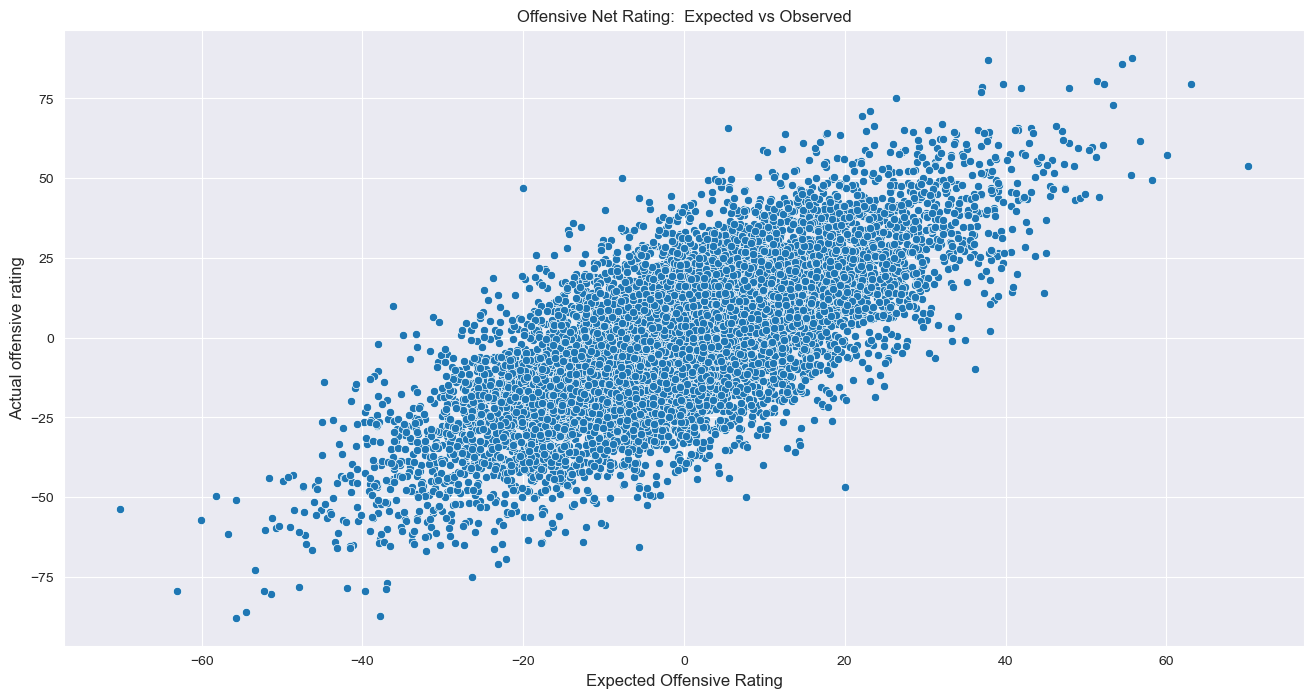

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.scatterplot(x = games_df.expected_nrtg,y = games_df.actual_nrtg)
plt.title("Offensive Net Rating:  Expected vs Observed")
plt.xlabel("Expected Offensive Rating",size = 12)
plt.ylabel("Actual offensive rating",size = 12)
plt.show();